# 🪸 Coral Image Classification with CNN

## Classifying Bleached vs Healthy Corals Using Deep Learning

This notebook explores the development of a convolutional neural network (CNN) to classify images of coral reefs as either **bleached** or **healthy**. The dataset is organized into labeled folders and processed using TensorFlow’s image pipeline. The final model will be trained, evaluated, and saved for use in a Streamlit-powered coral health detection app.

In [1]:
# Imports
import tensorflow as tf
import os
import cv2
#import imghdr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

2025-06-08 03:26:48.251371: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 03:26:48.253832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 03:26:48.288449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 03:26:48.288957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 03:26:49.013386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Load Data

In [2]:
data = tf.keras.utils.image_dataset_from_directory('../Data')

Found 923 files belonging to 2 classes.


In [3]:
bleached_count = 0
healthy_count = 0

for _, labels in data:
    labels = labels.numpy()
    bleached_count += np.sum(labels == 0)
    healthy_count += np.sum(labels == 1)

print(f"Bleached corals: {bleached_count}")
print(f"Healthy corals: {healthy_count}")

2025-06-08 03:26:50.533867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [923]
	 [[{{node Placeholder/_0}}]]
2025-06-08 03:26:50.534349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [923]
	 [[{{node Placeholder/_0}}]]


Bleached corals: 485
Healthy corals: 438


In [4]:
data_iter = data.as_numpy_iterator()

In [5]:
batch = data_iter.next()
batch[0].shape

(32, 256, 256, 3)

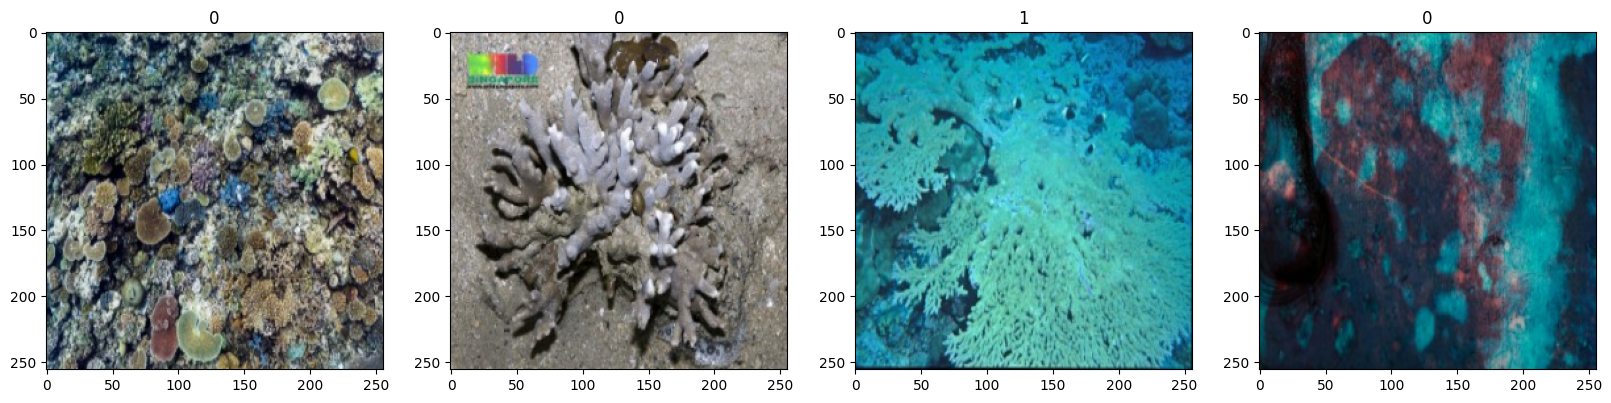

In [6]:
# Plot images in the batch
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype('int'))
    ax[idx].set_title(batch[1][idx])

- Class 0 : Bleached Corals
- Class 1 : Healthy Corals

## Preprocess Data

### Scale Data

In [7]:
data = data.map(lambda x,y: (x/255,y)) # gives values between 0-1

In [8]:
# Check max and min value
data.as_numpy_iterator().next()[0].max() ,data.as_numpy_iterator().next()[0].min()

2025-06-08 03:26:51.630755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [923]
	 [[{{node Placeholder/_0}}]]
2025-06-08 03:26:51.631003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [923]
	 [[{{node Placeholder/_0}}]]


(1.0, 0.0)

In [9]:
scaled_iter = data.as_numpy_iterator()
batch = scaled_iter.next()

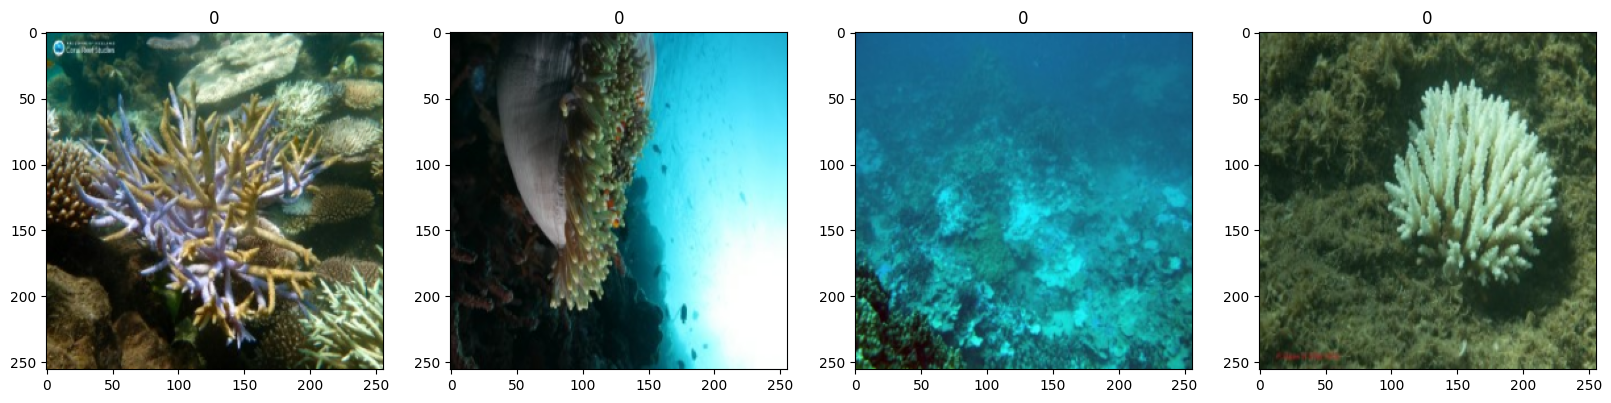

In [10]:
# Plot images in the batch
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

### Split Data

In [11]:
len(data) # 29 batches

29

In [12]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1) + 1

In [13]:
train_size + val_size + test_size

29

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## Create Model

### Build a Model

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(16, (3,3),1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add this
model.add(Dense(1, activation='sigmoid'))


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Train Model

In [19]:
logdir = '../Logs'

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                # stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True
)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback, early_stop])


Epoch 1/10


2025-06-08 03:26:53.078453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [923]
	 [[{{node Placeholder/_4}}]]
2025-06-08 03:26:53.078848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [923]
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5656

2025-06-08 03:26:58.433698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [923]
	 [[{{node Placeholder/_4}}]]
2025-06-08 03:26:58.433961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [923]
	 [[{{node Placeholder/_4}}]]


20/20 [==============================] - 6s 247ms/step - loss: 0.6850 - accuracy: 0.5656 - val_loss: 0.5862 - val_accuracy: 0.6979
Epoch 2/10
20/20 [==============================] - 5s 237ms/step - loss: 0.5949 - accuracy: 0.6969 - val_loss: 0.5310 - val_accuracy: 0.7448
Epoch 3/10
20/20 [==============================] - 5s 241ms/step - loss: 0.5284 - accuracy: 0.7156 - val_loss: 0.5282 - val_accuracy: 0.7135
Epoch 4/10
20/20 [==============================] - 5s 240ms/step - loss: 0.5231 - accuracy: 0.7453 - val_loss: 0.4894 - val_accuracy: 0.7396
Epoch 5/10
20/20 [==============================] - 5s 236ms/step - loss: 0.5256 - accuracy: 0.7422 - val_loss: 0.4660 - val_accuracy: 0.7552
Epoch 6/10
20/20 [==============================] - 5s 244ms/step - loss: 0.5287 - accuracy: 0.7141 - val_loss: 0.5128 - val_accuracy: 0.6979
Epoch 7/10
20/20 [==============================] - 5s 253ms/step - loss: 0.4462 - accuracy: 0.7922 - val_loss: 0.4683 - val_accuracy: 0.7656
Epoch 8/10
20/20 

### Plot Performance

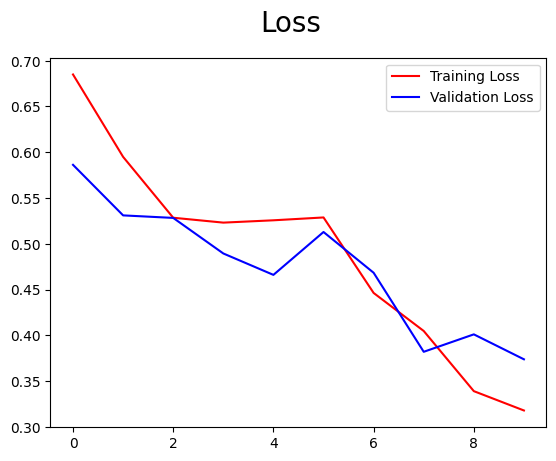

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'Training Loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

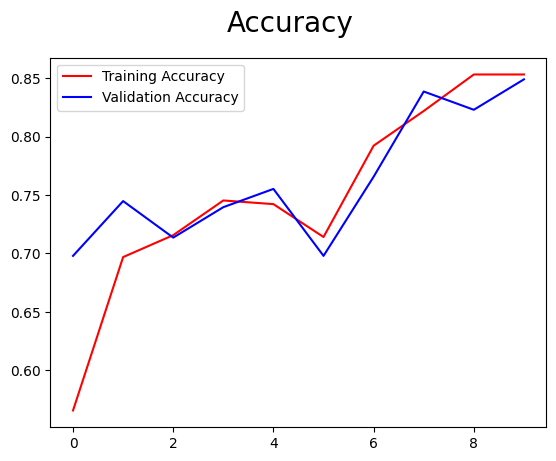

In [23]:
# Plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'red', label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'Validation Accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate Performance

In [24]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)

2025-06-08 03:27:45.143668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [923]
	 [[{{node Placeholder/_4}}]]
2025-06-08 03:27:45.144170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [923]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 119ms/step


In [25]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {rec.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.8444444537162781
Recall: 0.7916666865348816
Accuracy: 0.8131868243217468


### Test

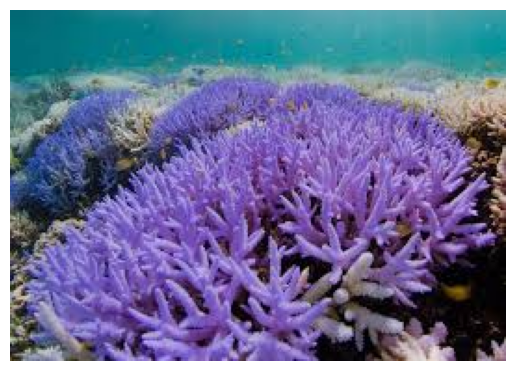

In [30]:
img = cv2.imread('../test_images/healthy1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

plt.show()  

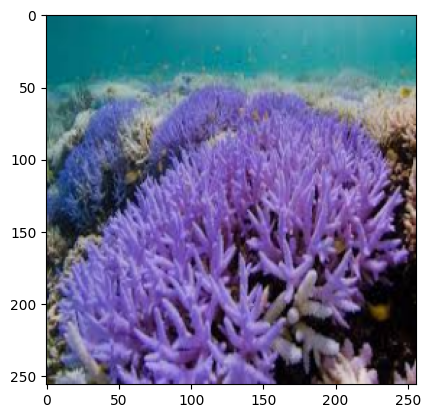

In [31]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype('int'))
plt.show()

In [32]:
yhat = model.predict(np.expand_dims(resize/255, axis=0))

1/1 [==============================] - 0s 20ms/step


In [33]:
yhat

array([[0.34197724]], dtype=float32)

In [34]:
if yhat < 0.5:
    print('Bleached')
else:
    print('Healthy')

Bleached


In [35]:
y_true = []
y_pred = []

for images, labels in val:  # or use test if available
    preds = model.predict(images)
    preds = tf.round(preds).numpy().flatten()  # Round sigmoid outputs to 0 or 1
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

1/1 [==============================] - 0s 73ms/step


In [36]:
y_true_tf = tf.constant(np.array(y_true).astype(int), dtype=tf.int32)
y_pred_tf = tf.constant(np.array(y_pred).astype(int), dtype=tf.int32)

# Step 3: Compute confusion matrix
conf_matrix = tf.math.confusion_matrix(
    labels=y_true_tf,
    predictions=y_pred_tf,
    num_classes=2
)

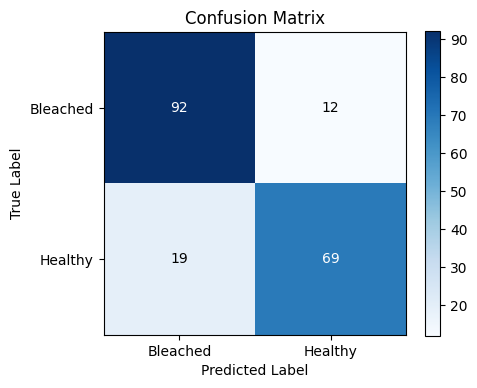

In [37]:
# Step 4: Plot the confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Annotate the matrix
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j].numpy()
        plt.text(j, i, str(count),
                 ha='center', va='center',
                 color='white' if count > 0.5 * tf.reduce_max(conf_matrix).numpy() else 'black')

plt.xticks([0, 1], ['Bleached', 'Healthy'])
plt.yticks([0, 1], ['Bleached', 'Healthy'])
plt.colorbar()
plt.tight_layout()
plt.show()

## Saving the Model

In [ ]:
model.save(os.path.join('../Models' , 'coral_classifier.h5'))

In [ ]:
new_model = load_model(os.path.join('../Models' , 'coral_classifier.h5'))


In [40]:
yhat_new = new_model.predict(np.expand_dims(resize/255, axis=0))

1/1 [==============================] - 0s 64ms/step


In [41]:
if yhat_new < 0.5:
    print('Bleached')
else:
    print('Healthy')

Bleached
